In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#
# Project 2, starter code Part a
#

import math
import tensorflow as tf
import numpy as np
import pylab as plt
import pickle

In [0]:
NUM_CLASSES = 10
IMG_SIZE = 32
NUM_CHANNELS = 3
learning_rate = 0.001
epochs = 100
batch_size = 1

seed = 10
np.random.seed(seed)
tf.set_random_seed(seed)

In [0]:
def load_data(file):
    with open(file, 'rb') as fo:
        try:
            samples = pickle.load(fo)
        except UnicodeDecodeError:  #python 3.x
            fo.seek(0)
            samples = pickle.load(fo, encoding='latin1')

    data, labels = samples['data'], samples['labels']

    data = np.array(data, dtype=np.float32)
    labels = np.array(labels, dtype=np.int32)


    labels_ = np.zeros([labels.shape[0], NUM_CLASSES])
    labels_[np.arange(labels.shape[0]), labels-1] = 1

    return data, labels_

In [0]:
def cnn(images, c1_filters, c2_filters):
    images = tf.reshape(images, [-1, IMG_SIZE, IMG_SIZE, NUM_CHANNELS])

    # C1 (50x24x24): Conv layer, 50 filters, window size 9x9, VALID padding, ReLU
    # S1 (50x12x12): Max pooling layer, window size 2x2, stride = 2, VALID padding
    W1 = tf.Variable(tf.truncated_normal([9, 9, NUM_CHANNELS, c1_filters], stddev=1.0/np.sqrt(NUM_CHANNELS*9*9)), name='weights_1')
    b1 = tf.Variable(tf.zeros([c1_filters]), name='biases_1')  
    conv_1 = tf.nn.relu(tf.nn.conv2d(images, W1, [1, 1, 1, 1], padding='VALID') + b1)
    pool_1 = tf.nn.max_pool(conv_1, ksize= [1, 2, 2, 1], strides= [1, 2, 2, 1], padding='VALID', name='pool_1')

    # C2 (60x8x8): Conv layer, 60 filters, window size 5x5, VALID padding, ReLU
    # S2 (60x4x4): Max pooling layer, window size 2x2, stride = 2, VALID padding
    W2 = tf.Variable(tf.truncated_normal([5, 5, c1_filters, c2_filters], stddev=1.0/np.sqrt(c1_filters*5*5)), name='weights_2')
    b2 = tf.Variable(tf.zeros([c2_filters]), name='biases_2')
    conv_2 = tf.nn.relu(tf.nn.conv2d(pool_1, W2, [1, 1, 1, 1], padding='VALID') + b2)
    pool_2 = tf.nn.max_pool(conv_2, ksize= [1, 2, 2, 1], strides= [1, 2, 2, 1], padding='VALID', name='pool_2')

    # Flatten (dim = 60x4x4 = 960)
    dim = pool_2.get_shape()[1].value * pool_2.get_shape()[2].value * pool_2.get_shape()[3].value 
    pool_2_flat = tf.reshape(pool_2, [-1, dim])

    # F3: Fully connected layer of size 300 (960 -> 300)
    W3 = tf.Variable(tf.truncated_normal([dim, 300], stddev=1.0/np.sqrt(dim)), name='weights_3')
    b3 = tf.Variable(tf.zeros([300]), name='biases_3')
    f3_logits = tf.matmul(pool_2_flat, W3) + b3

    # F4: Softmax layer of size 10 (300 -> 10)
    W4 = tf.Variable(tf.truncated_normal([300, NUM_CLASSES], stddev=1.0/np.sqrt(300)), name='weights_4')
    b4 = tf.Variable(tf.zeros([NUM_CLASSES]), name='biases_4')
    f4_logits = tf.matmul(f3_logits, W4) + b4

    return conv_1, pool_1, conv_2, pool_2, f4_logits

In [6]:
# Main Program
if __name__ == '__main__':
    trainX, trainY = load_data('/content/drive/My Drive/NTU - Year 3 Sem 1/CZ4042 Neural Network/Project 2/data_batch_1')
    print(trainX.shape, trainY.shape)

    testX, testY = load_data('/content/drive/My Drive/NTU - Year 3 Sem 1/CZ4042 Neural Network/Project 2/test_batch_trim')
    print(testX.shape, testY.shape)

    # Scaling the train & test inputs
    trainX = (trainX - np.min(trainX, axis = 0))/np.max(trainX, axis = 0)
    testX = (testX - np.min(testX, axis = 0))/np.max(testX, axis = 0)

    # Create the model
    x = tf.placeholder(tf.float32, [None, NUM_CHANNELS*IMG_SIZE*IMG_SIZE]) # 3x32x32
    y_ = tf.placeholder(tf.float32, [None, NUM_CLASSES])

    c1, s1, c2, s2, logits = cnn(x, 310, 210)

    cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_, logits=logits)
    loss = tf.reduce_mean(cross_entropy)

    #   train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
    train_step = tf.train.MomentumOptimizer(learning_rate,0.1).minimize(loss)

    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y_, 1))
    correct_prediction = tf.cast(correct_prediction, tf.float32)
    accuracy = tf.reduce_mean(correct_prediction)

    N = len(trainX)
    idx = np.arange(N)

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        train_loss = []
        test_acc = []

        for e in range(epochs):
            np.random.shuffle(idx)
            trainX, trainY = trainX[idx], trainY[idx]
            temp_train_loss = []

            for start, end in zip(range(0, N, batch_size), range(batch_size, N, batch_size)):
                # train_step.run(feed_dict={x: trainX[start:end], y_: trainY[start:end]})
                # temp_train_loss.append(loss.eval(feed_dict={x: trainX[start:end], y_: trainY[start:end]}))
                _, loss_ = sess.run([train_step, loss], {x: trainX[start:end], y_: trainY[start:end]})
                temp_train_loss.append(loss_)

            trainLoss = np.mean(np.array(temp_train_loss))
            testAcc = accuracy.eval(feed_dict={x: testX, y_: testY})
            train_loss.append(trainLoss)
            test_acc.append(testAcc)

            if (True): # e % 10 == 0 or e == epochs-1
                print('Epoch: ', e, ' | Train loss: ', trainLoss, ' | Test acc: ', testAcc)

(10000, 3072) (10000, 10)
(2000, 3072) (2000, 10)
Epoch:  0  | Train loss:  1.9914167  | Test acc:  0.38
Epoch:  1  | Train loss:  1.7280647  | Test acc:  0.4215
Epoch:  2  | Train loss:  1.6007408  | Test acc:  0.456
Epoch:  3  | Train loss:  1.5016875  | Test acc:  0.446
Epoch:  4  | Train loss:  1.4245571  | Test acc:  0.4815
Epoch:  5  | Train loss:  1.3465064  | Test acc:  0.468
Epoch:  6  | Train loss:  1.2705841  | Test acc:  0.494
Epoch:  7  | Train loss:  1.1838452  | Test acc:  0.488
Epoch:  8  | Train loss:  1.0888618  | Test acc:  0.511
Epoch:  9  | Train loss:  0.9869742  | Test acc:  0.487
Epoch:  10  | Train loss:  0.88296425  | Test acc:  0.494
Epoch:  11  | Train loss:  0.7685499  | Test acc:  0.509
Epoch:  12  | Train loss:  0.6519176  | Test acc:  0.497
Epoch:  13  | Train loss:  0.539504  | Test acc:  0.4895
Epoch:  14  | Train loss:  0.42757487  | Test acc:  0.4995
Epoch:  15  | Train loss:  0.33249018  | Test acc:  0.5155
Epoch:  16  | Train loss:  0.24485011  | T

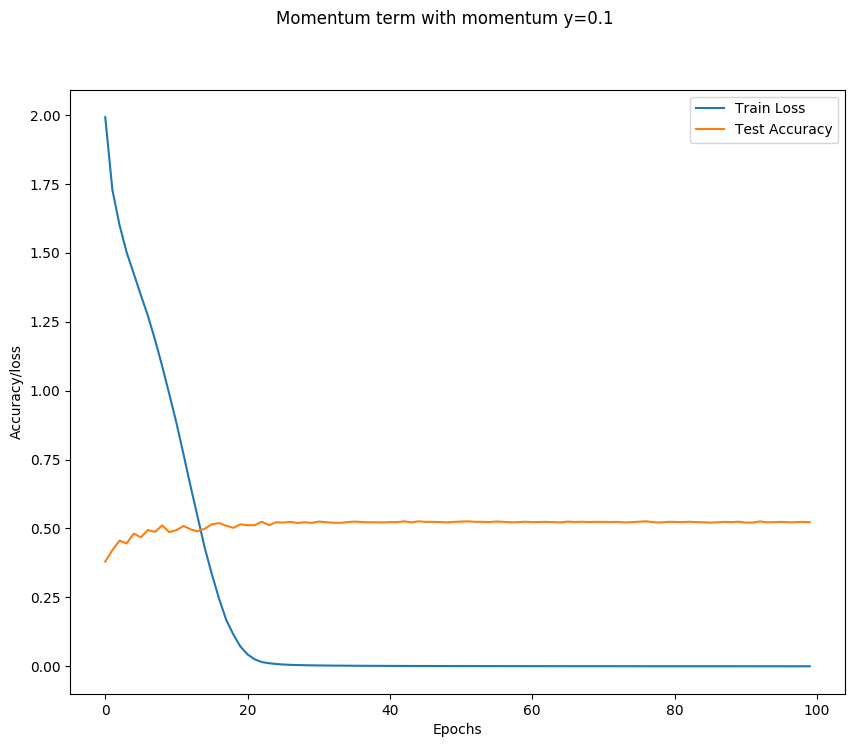

In [7]:
        # Plot train loss vs test acc
        plt.figure(figsize=(10, 8), dpi=100)
        plt.suptitle('Momentum term with momentum y=0.1')
        plt.plot(range(epochs), train_loss, label='Train Loss')
        plt.plot(range(epochs), test_acc, label='Test Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy/loss')
        plt.legend()
        plt.savefig('./3a.Momentum_SGD_TrainLoss_TestAcc.png')
        plt.show()